# SPICED Academy ///  Project Week 07 /// Time Analysis

***

## I. Define goal

The goal of this project is to build a model that is able to generate short-term temperature forecasts focusing on one specific location. The whole model was build on the average temperature from München (= Munich), whereas the data was retrieved from ecad (www.ecad.eu). 


___

## II. Import libraries and get data

In [1]:
#data processing
import pandas as pd
import numpy as np

#data visualization
import seaborn as sns
import matplotlib.pyplot as plt

#feature engineering
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import ar_select_order

#machine learning models
from statsmodels.tsa.ar_model import AutoReg
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

#metrics
from sklearn.metrics import mean_squared_error

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#open relevant files / mean temperature in Munich
temp_muc = pd.read_csv('muc.txt', sep=",")

***

## III. Cleaning the data 

In [3]:
#exploring the data
temp_muc.dtypes, temp_muc.columns

( SOUID      int64
     DATE    int64
    TG       int64
  Q_TG       int64
 dtype: object,
 Index([' SOUID', '    DATE', '   TG', ' Q_TG'], dtype='object'))

In [4]:
#removing unnecessary columns
temp_muc = temp_muc.drop([' SOUID', ' Q_TG'], axis =1)

In [5]:
#renaming the columns
temp_muc.rename(columns={'    DATE':'date', '   TG': 'ave_temp'}, inplace = True)

In [6]:
#setting date as index and setting it as datetime
temp_muc['date'] = pd.to_datetime(temp_muc['date'], format='%Y%m%d')
temp_muc.set_index(['date'], inplace=True)

In [7]:
#transforming the average 
temp_muc['ave_temp'] = temp_muc['ave_temp']*0.1
temp_muc.head()

,ave_temp
date,
1879-01-01,7.0
1879-01-02,3.5
1879-01-03,3.9
1879-01-04,4.0
1879-01-05,-1.7


***

## IV. Exploring the data set and checking for outliers

*Average temperature in Munich including the war*

In [8]:
#the min of -999.90 is very surprising > plotting 
temp_muc.describe()

,ave_temp
count,52138.000000
mean,7.084353
std,42.400844
min,-999.900000
25%,2.600000
50%,9.100000
75%,15.200000
max,30.400000


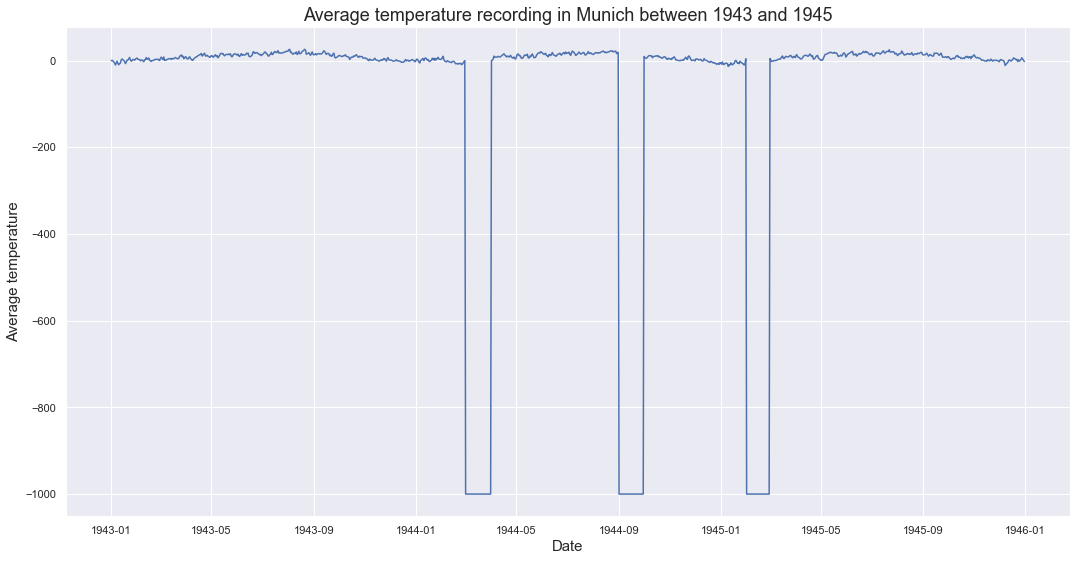

In [10]:
#interesting fact: apparently temperature recording was stopped a couple of times during worl war II
temp_muc_war = temp_muc['1943-01-01':'1945-12-31']
temp_muc_war 
sns.lineplot(data=temp_muc_war, x='date', y='ave_temp')
sns.set_theme(style="whitegrid", palette = "Set2")
sns.set(rc = {'figure.figsize':(18,9)})
plt.xlabel('Date', size=15)
plt.ylabel('Average temperature', size=15)
plt.title('Average temperature recording in Munich between 1943 and 1945', size=18);

***

*Average temperature in Munich from 1950s onwards*

In [11]:
#when looking at the temperature observations from 1950s onwards, the descriptive measurements make much more sense
temp_muc = temp_muc['1950':]
temp_muc['1950':].describe()

,ave_temp
count,26206.000000
mean,9.494005
std,7.929444
min,-20.000000
25%,3.300000
50%,9.800000
75%,15.800000
max,30.400000


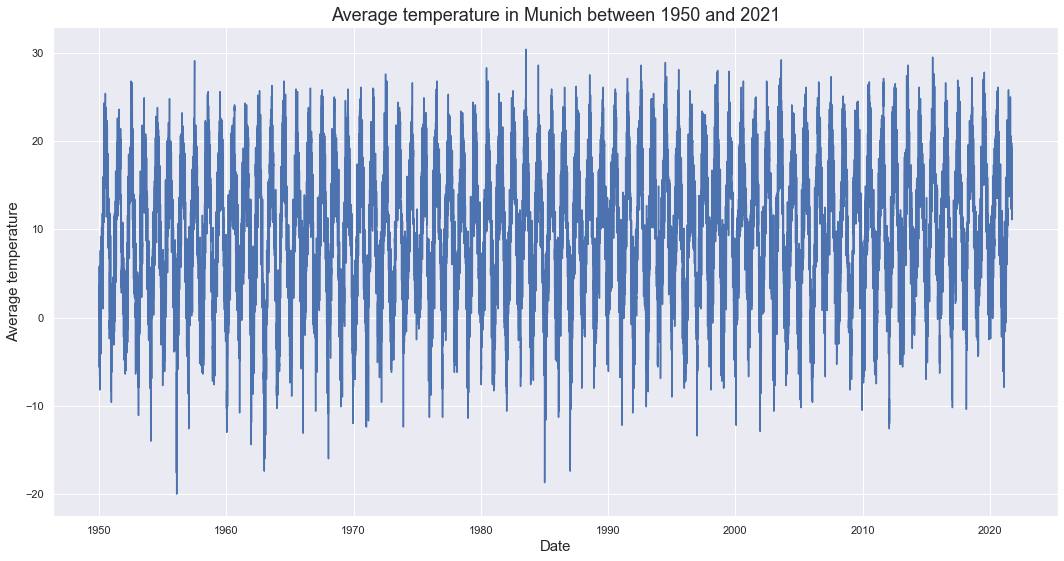

In [12]:
#plotting the average temperature in Munic from 1950 to 2021
ax = sns.lineplot(data=temp_muc, x="date", y="ave_temp")
plt.xlabel('Date', size=15)
plt.ylabel('Average temperature', size=15)
plt.title('Average temperature in Munich between 1950 and 2021', size=18);

<font color='blue'>Summary: </font>Due to the gaps in the recordings during the 1940s (World War II) and in order to reduce the amount of observations, the temperature data from 1950s onwards will be observed meaning post-war to nowadays.

***

## V. Feature Engineering

*Defining timstep, X and y*

In [13]:
#defining timestep
temp_muc['timestep'] = range(len(temp_muc))

In [14]:
#defining X and y
X = temp_muc[['timestep']]
y = temp_muc['ave_temp']

***

*Splitting into training and test data*

In [15]:
#exploring 80% of the dataset to split the data into train and test
temp_muc.describe
temp_muc.iloc[20964]

ave_temp       21.9
timestep    20964.0
Name: 2007-05-26 00:00:00, dtype: float64

In [16]:
#splitting the data into train and test
train_temp_muc = temp_muc[:20_964] #total count is 26_206 > 20_964 is 80% of all datapoints from 26_206 datapoints in total 
X_train = X[:20_964] 
y_train = y[:20_964]

test_temp_muc = temp_muc[20_964:] #test data
X_test = X[20_964:]
y_test = y[20_964:]

In [17]:
#checkin out if the splitting worked & examing the total row count for X_temp_muc
train_temp_muc

,ave_temp,timestep
date,,
1950-01-01,-5.6,0
1950-01-02,-0.2,1
1950-01-03,1.0,2
1950-01-04,0.9,3
1950-01-05,3.0,4
...,...,...
2007-05-21,21.9,20959
2007-05-22,19.9,20960
2007-05-23,21.4,20961


***

*Augmented Dickey-Fuller Test (before Feature Engineering is applied)*

In [18]:
#applying Augmented Dickey-Fuller Test (before Feature Engineering)
ADF_beforeFE = adfuller(train_temp_muc['ave_temp'], autolag='AIC')
print(f'ADF Statistic: {round(ADF_beforeFE[0],2)}')
print(f'p-value: {round(ADF_beforeFE[1],2)}')
for key, value in ADF_beforeFE[4].items():
    print('Critial Values:')
    print(f'   {key}, {round(value,2)}')

ADF Statistic: -10.57
p-value: 0.0
Critial Values:
   1%, -3.43
Critial Values:
   5%, -2.86
Critial Values:
   10%, -2.57


***

*Slicing out the temperature´s trend (only for the training data)*

In [19]:
#instantiating and fitting a Linear Regression model to X_train and y_train
m = LinearRegression()
m.fit(X_train, y_train)

LinearRegression()

In [20]:
#adding 'trend' to the dataframe X_temp_muc
train_temp_muc['trend'] = m.predict(X_train)

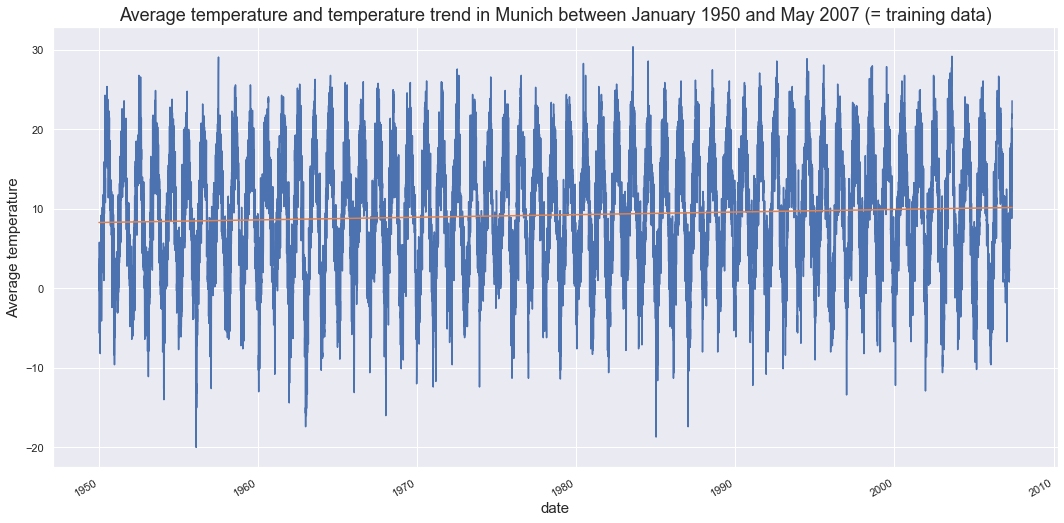

In [21]:
#plotting the average temperature recordings & trend for 80% of the datapoints
ax = sns.lineplot(data=train_temp_muc, x="date", y="ave_temp")
plt.xlabel('Date', size=15)
plt.ylabel('Average temperature', size=15)
plt.title('Average temperature and temperature trend in Munich between January 1950 and May 2007 (= training data)', size=18)
train_temp_muc['trend'].plot();

***

*Slicing out seasonality and trend (for the train and test data)*

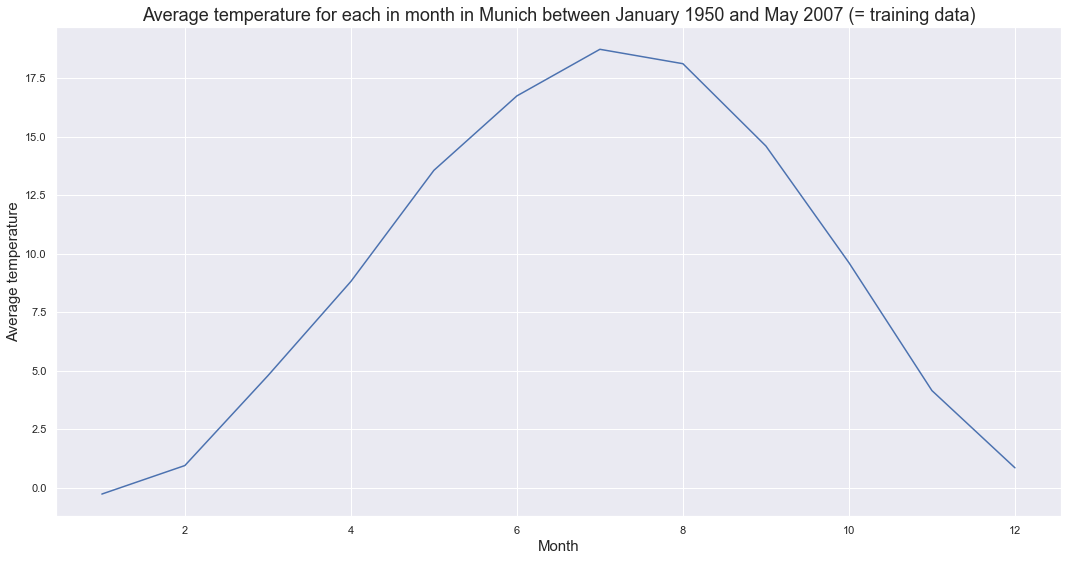

In [22]:
#portraying seasonality / average temperature for each month in Munich from 1950s onwards (for 80% of the datapoints)
ax = train_temp_muc.groupby(train_temp_muc.index.month)['ave_temp'].mean().plot()
plt.xlabel('Month', size=15)
plt.ylabel('Average temperature', size=15)
plt.title('Average temperature for each in month in Munich between January 1950 and May 2007 (= training data)', size=18);

In [23]:
#get dummies for all months (for train & test data)
train_month_dummies = pd.get_dummies(train_temp_muc.index.month, drop_first=True, prefix='month').set_index(train_temp_muc.index)

test_month_dummies = pd.get_dummies(test_temp_muc.index.month, drop_first=True, prefix='month').set_index(test_temp_muc.index)

In [24]:
#attach the "month_dummies" to the dataframe and drop ave_temp and trend (for train & test data)
train_temp_muc = train_temp_muc.join(train_month_dummies)
X_train = train_temp_muc.drop(['ave_temp', 'trend'], axis =1)


test_temp_muc = test_temp_muc.join(test_month_dummies)
X_test = test_temp_muc.drop(['ave_temp'], axis =1)

In [25]:
#checking X_train
X_train.head()

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,
1950-01-01,0,0,0,0,0,0,0,0,0,0,0,0
1950-01-02,1,0,0,0,0,0,0,0,0,0,0,0
1950-01-03,2,0,0,0,0,0,0,0,0,0,0,0
1950-01-04,3,0,0,0,0,0,0,0,0,0,0,0
1950-01-05,4,0,0,0,0,0,0,0,0,0,0,0


In [26]:
#fitting the seasonality to Linear Regression
m.fit(X_train, y_train) #X are the months aka seasonality as well as trend (timestep), y is ave_temp

LinearRegression()

In [27]:
#predicting the seasonality
train_temp_muc['trend_seasonal'] = m.predict(X_train)
test_temp_muc['trend_seasonal'] = m.predict(X_test)

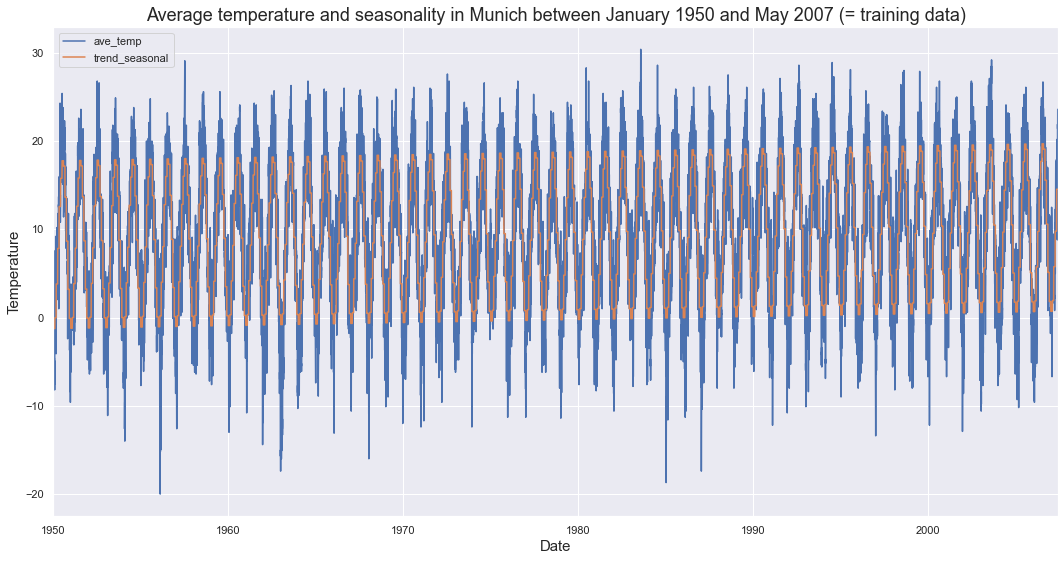

In [28]:
#plotting seasonality vs. ave_temp
train_temp_muc[['ave_temp', 'trend_seasonal']].plot()
plt.xlabel('Date', size=15)
plt.ylabel('Temperature', size=15)
plt.title('Average temperature and seasonality in Munich between January 1950 and May 2007 (= training data)', size=18);

***

*Slicing out the remainder (for the train and test data)*

In [29]:
#Substracting trend&seasonality from the average temperature /// for train as well as test data
train_temp_muc['remainder'] = train_temp_muc['ave_temp'] - train_temp_muc['trend_seasonal'] 
test_temp_muc['remainder'] = test_temp_muc['ave_temp'] - test_temp_muc['trend_seasonal'] 

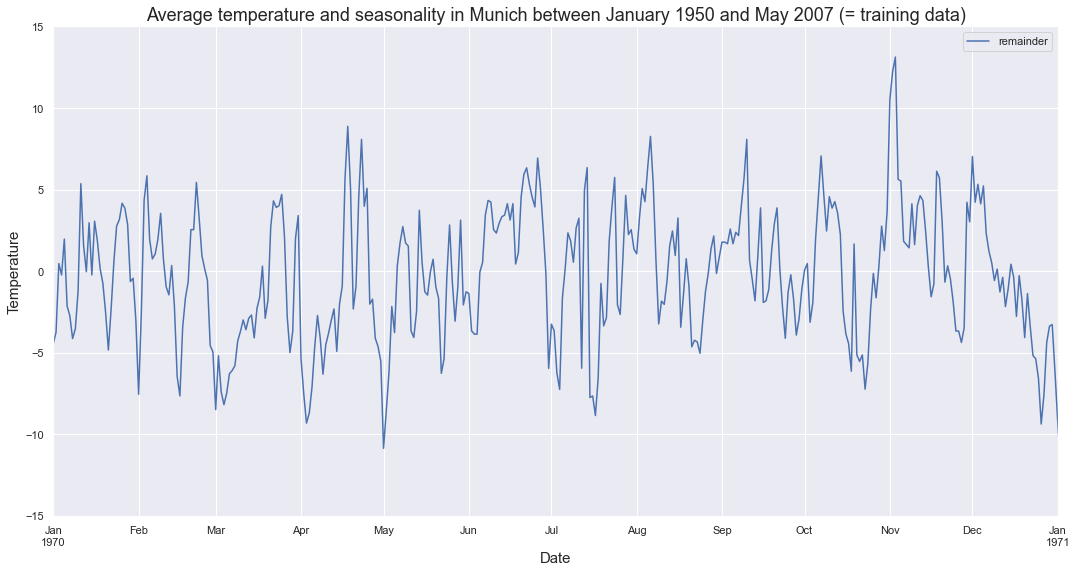

In [30]:
#plotting seasonality vs. ave_temp
train_temp_muc[['remainder']].plot()
plt.xlabel('Date', size=15)
plt.ylabel('Temperature', size=15)
plt.axis([0, 365, -15, 15]) #zooming into the data
plt.title('Average temperature and seasonality in Munich between January 1950 and May 2007 (= training data)', size=18);

***

*Augmented Dickey-Fuller Test (after Feature Engineering is applied)*

In [31]:
#applying Augmented Dickey-Fuller Test (before Feature Engineering)
ADF_beforeFE = adfuller(train_temp_muc['remainder'], autolag='AIC')
print(f'ADF Statistic: {round(ADF_beforeFE[0],2)})')
print(f'p-value: {round(ADF_beforeFE[1],2)}')
for key, value in ADF_beforeFE[4].items():
    print('Critial Values:')
    print(f'   {key}, {round(value,2)}')

ADF Statistic: -44.35)
p-value: 0.0
Critial Values:
   1%, -3.43
Critial Values:
   5%, -2.86
Critial Values:
   10%, -2.57


In [32]:
#Comparing Augmented Dickey-Fuller Test before and after Feature Engineering 
comparison = pd.DataFrame({'Metrics' : ['ADF Statistic:', 'p-value:', 'Critial Values: 1%', 'Critial Values: 5%', 'Critial Values: 10%'], 'ADF before FE' : ['-10.57', '0.0', '-3.43', '-2.86', '-2.57'], 'ADF after FE' : ['-44.35', '0.0', '-3.43', '-2.86', '-2.57']})
comparison.set_index('Metrics')

,ADF before FE,ADF after FE
Metrics,,
ADF Statistic:,-10.57,-44.35
p-value:,0.0,0.0
Critial Values: 1%,-3.43,-3.43
Critial Values: 5%,-2.86,-2.86
Critial Values: 10%,-2.57,-2.57


<font color='blue'>Augmented Dickey-Fuller Test</font> Null-hypothesis of the Augmented Dickey-Fuller Test (ADF) is that the data is non-stationary. As both of the obtained p-values are at the significance level of 0.00, the null-hypothesis can be rejected. This means that the time series was stationary <ins>before and after</ins> feature engineering. At least the ADF Statistic improved from the first (-12.51) to the second (-44.35) ADF test, meaning that the removal of trend and seasonality had an influence on stationarity, however the removal was not necessary at all.<br><br> This is very surprising as the time series before feature engineering contains the remainder, seasonality and trend, which does not seem to be stationary at all.

***

*Selecting and plotting the number of lags*

In [33]:
#selecting lags
selected_lags = ar_select_order(train_temp_muc['ave_temp'], maxlag=365)

In [34]:
#applying ar_lags to "selected order"
selected_lags.ar_lags #the amount of lags is 17 

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

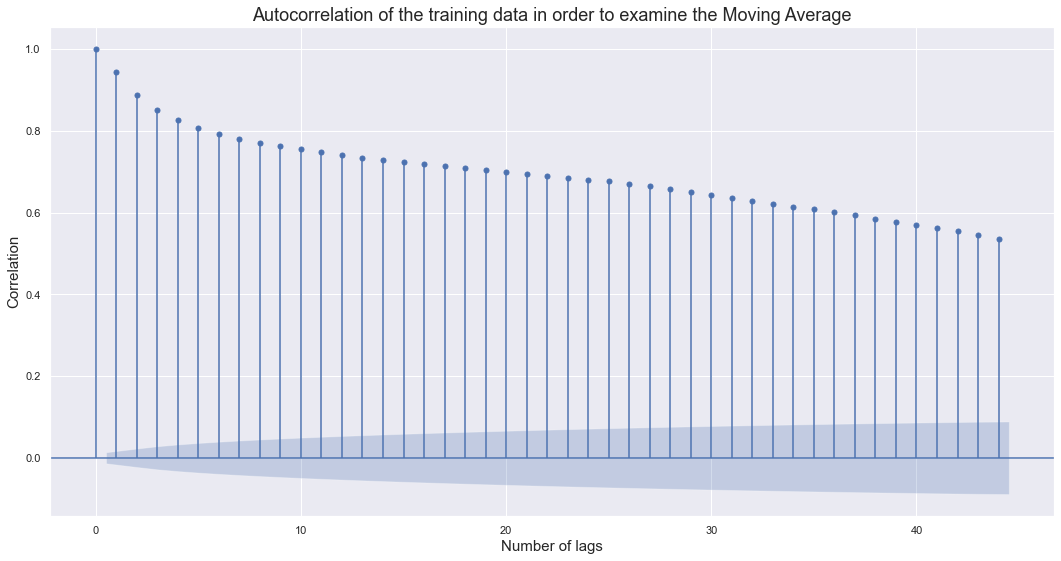

In [35]:
#plotting the number of lags - autocorrelation 
plot_acf(train_temp_muc['ave_temp']);
plt.xlabel('Number of lags', size=15)
plt.ylabel('Correlation', size=15)
plt.title('Autocorrelation of the training data in order to examine the Moving Average', size=18);

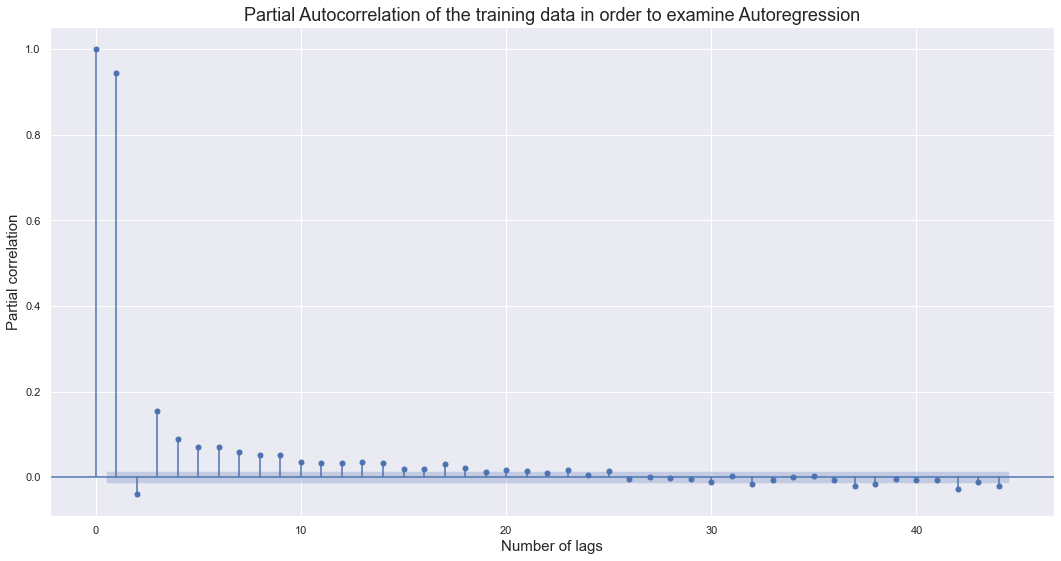

In [36]:
#plotting the number of lags - partial autocorrelation
plot_pacf(train_temp_muc['ave_temp'])
plt.xlabel('Number of lags', size=15)
plt.ylabel('Partial correlation', size=15)
plt.title('Partial Autocorrelation of the training data in order to examine Autoregression', size=18);

<font color='blue'>Summary: </font> According to the Augmented Dickey-Fuller Test it seems that the orginal dataset is already stationary, meaning that an autoregressive model will be applied in the following steps. This finding is also supported by the autocorrelation plot as it does not contain a Moving Average. 

Generally, the application of an ARIMA model does not seem to be necessary.

***

## VI. Train model

*Applying an Autoregressive Model on the training dataset*

In [41]:
#instantiating and fitting the model
ar_m_train = AutoReg(endog=train_temp_muc['ave_temp'], lags=17).fit() #instantiates and fits the Autoregressive Model 

In [42]:
#calculating the prediction for training data set
train_predict = ar_m_train.predict()

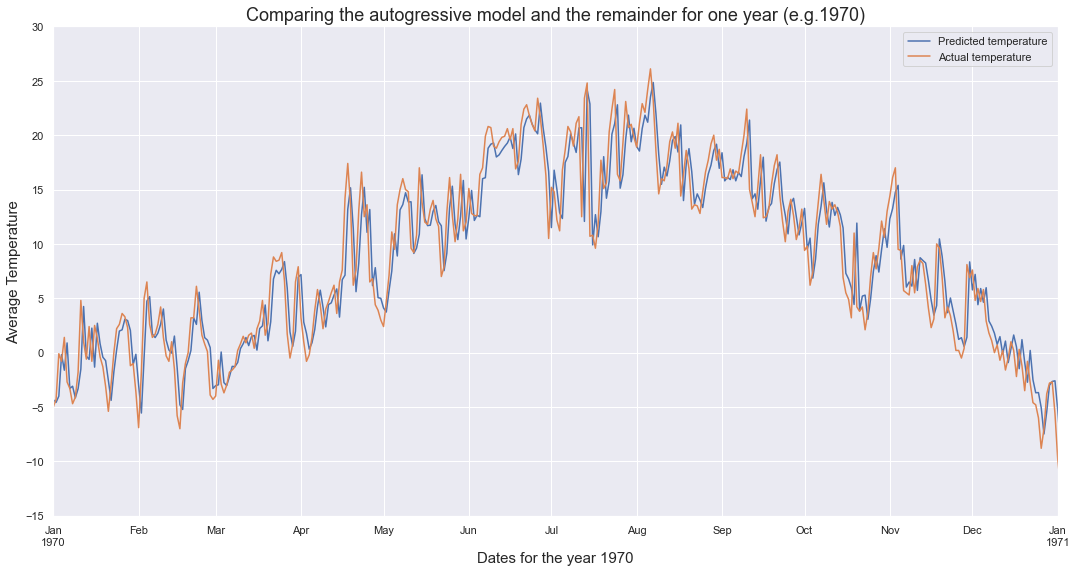

In [56]:
#plotting the autogressive model and the remainder for one year
train_predict.plot(label='Predicted temperature')
train_temp_muc['ave_temp'].plot(label='Actual temperature')
plt.legend();#autogressive model and remainder have the same plot 
plt.axis([0, 365, -15, 30]) #zooming into the data
plt.xlabel('Dates for the year 1970', size=15)
plt.ylabel('Average Temperature', size=15)
plt.title('Comparing the predicted and actual temperature for one year (e.g.1970)', size=18);

***

## VII. HYPERPARAMETER OPTIMIZATION

*AIC vs BIC*

In [44]:
#checking out the AIC and BIC for the train data
ar_m_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:               ave_temp   No. Observations:                20964
Model:                    AutoReg(17)   Log Likelihood              -49217.055
Method:               Conditional MLE   S.D. of innovations              2.536
Date:                Mon, 15 Nov 2021   AIC                              1.863
Time:                        13:23:20   BIC                              1.870
Sample:                    01-18-1950   HQIC                             1.865
                         - 05-25-2007                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.2368      0.029      8.305      0.000       0.181       0.293
ave_temp.L1      0.9455      0.007    136.909      0.000       0.932       0.959
ave_temp.L2     -0.1852      0.010    -19.481      0.000      -0.204      -0.167
ave_temp.L3      0.0688      0.010      7.173      0.000       0.050       0.088
ave_temp.L4      0.0222      0.010      2.307      0.021       0.003       0.041
ave_temp.L5      0.0063      0.010      0.655      0.512      -0.013       0.025
ave_temp.L6      0.0167      0.010      1.739      0.082      -0.002       0.036
ave_temp.L7      0.0132      0.010      1.373      0.170      -0.006       0.032
ave_temp.L8      0.0025      0.010      0.257      0.797      -0.016       0.021
ave_temp.L9      0.0221      0.010      2.302      0.021       0.003       0.041
ave_temp.L10     0.0041      0.010      0.427      0.669      -0.015       0.023
ave_temp.L11     0.0051      0.010      0.532      0.594      -0.014       0.024
ave_temp.L12     0.0046      0.010      0.479      0.632      -0.014       0.023
ave_temp.L13     0.0046      0.010      0.474      0.636      -0.014       0.023
ave_temp.L14     0.0168      0.010      1.746      0.081      -0.002       0.036
ave_temp.L15     0.0058      0.010      0.609      0.543      -0.013       0.025
ave_temp.L16    -0.0091      0.010     -0.959      0.337      -0.028       0.010
ave_temp.L17     0.0307      0.007      4.441      0.000       0.017       0.044
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.0110           -0.0000j            1.0110           -0.0000
AR.2             1.1037           -0.3833j            1.1683           -0.0532
AR.3             1.1037           +0.3833j            1.1683            0.0532
AR.4             0.9414           -0.7702j            1.2163           -0.1091
AR.5             0.9414           +0.7702j            1.2163            0.1091
AR.6             0.6438           -1.0802j            1.2575           -0.1645
AR.7             0.6438           +1.0802j            1.2575            0.1645
AR.8             0.2319           -1.2208j            1.2427           -0.2201
AR.9             0.2319           +1.2208j            1.2427            0.2201
AR.10           -0.2506           -1.2167j            1.2422           -0.2823
AR.11           -0.2506           +1.2167j            1.2422            0.2823
AR.12           -0.6954           -1.0441j            1.2545           -0.3435
AR.13           -0.6954           +1.0441j            1.2545            0.3435
AR.14           -1.0686           -0.6941j            1.2742           -0.4083
AR.15           -1.0686           +0.6941j            1.2742            0.4083
AR.16           -1.2629           -0.25

***

*MAE*

In [66]:
#checking out MAE
y_true = train_temp_muc['ave_temp'].iloc[17:] # y: real value = remainder of training data 
y_pred = train_predict.iloc[17:] # y_pred: predicted value = ar_m_train.predict() data - minus the first three rows of NaN
MAE = round(np.absolute(np.subtract(y_true, y_pred)).mean(),2)
print(F'The mean absolute error is {MAE} Celsius degrees.')

The mean absolute error is 1.98 Celsius degrees.


***

*RMSE*

In [67]:
#checking out the RMSE
RMSE = round(mean_squared_error(y_true, y_pred, squared=False),2)
print(F'The root mean squared error is {RMSE} Celsius degrees.')

The root mean squared error is 2.54 Celsius degrees.


***

*Examining residuals*

In [47]:
#calculating the difference between signal and predicted value
residuals = pd.DataFrame(ar_m_train.resid) 

In [48]:
#looking at the descriptive stats of the training residuals
round(residuals.describe(), 2)

,0
count,20947.00
mean,-0.00
std,2.54
min,-19.22
25%,-1.56
50%,0.08
75%,1.69
max,19.06


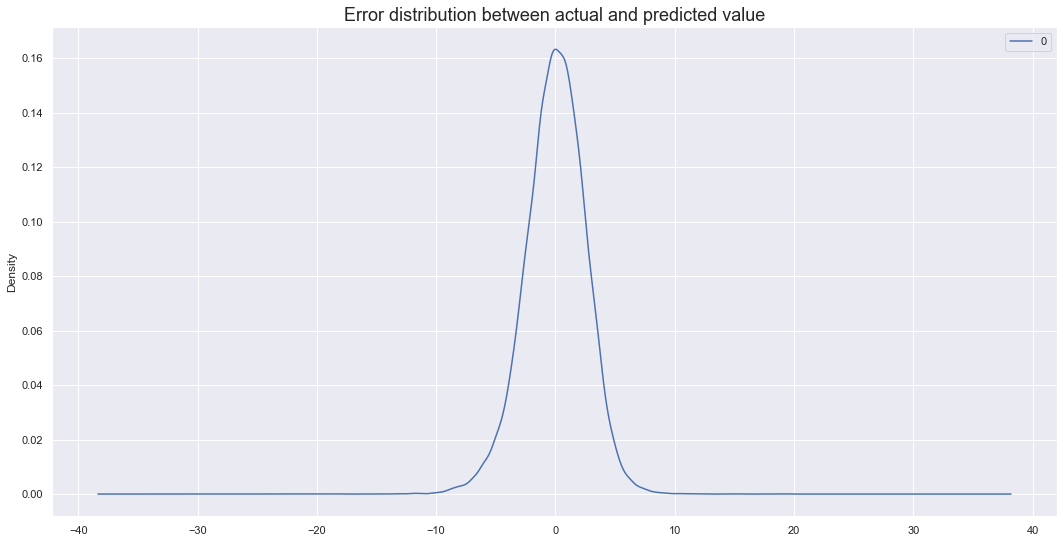

In [60]:
#checking the distribiution of the values
residuals.plot(kind = 'kde')
plt.title('Error distribution between actual and predicted value', size=18);

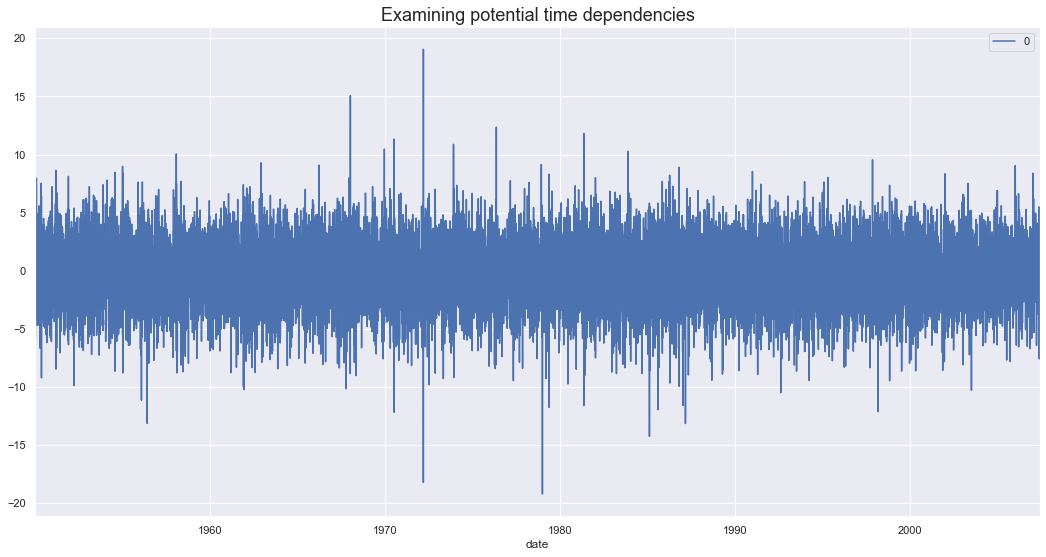

In [50]:
#checking for time dependency 
residuals.plot()
plt.title('Examining potential time dependencies', size=18);

***

## VIII. COMPARING TRAIN AND TEST DATA SET

*Applying an Autoregressive Model on the test dataset*

In [51]:
#instantiating and fitting the model
ar_m_test = AutoReg(endog=test_temp_muc['ave_temp'], lags=17).fit() #instantiates and fits the Autoregressive Model 

In [52]:
#calculating the prediction for test data set
test_predict = ar_m_test.predict()

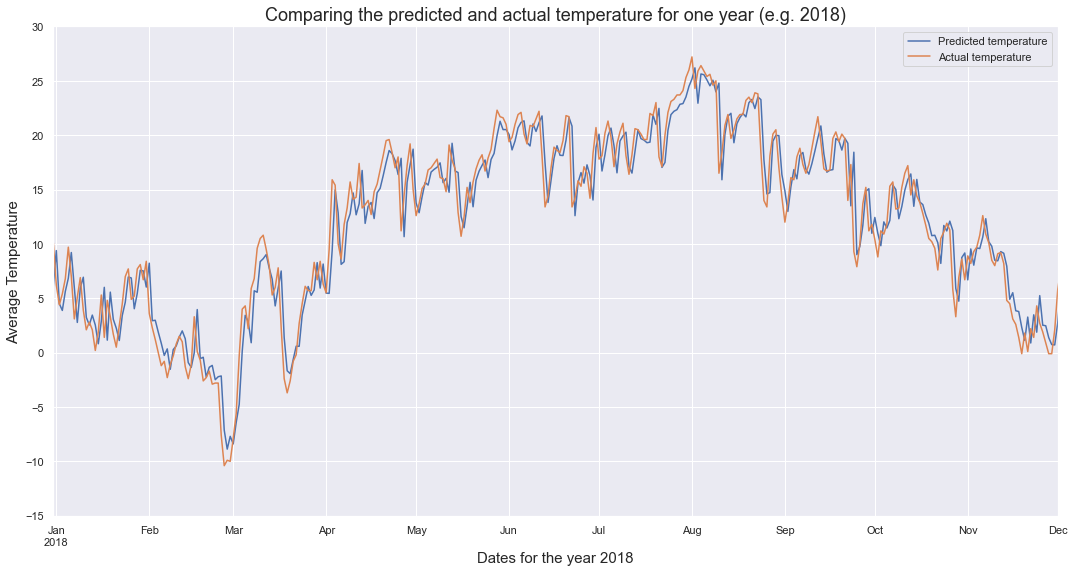

In [57]:
#plotting the autogressive model and the remainder for one year
ar_m_test.predict().plot(label='Predicted temperature')
test_temp_muc['ave_temp'].plot(label='Actual temperature')
plt.legend();#autogressive model and remainder have the same plot 
plt.axis([17531, 17866, -15, 30]) #zooming into the data
plt.xlabel('Dates for the year 2018', size=15)
plt.ylabel('Average temperature', size=15)
plt.title('Comparing the predicted and actual temperature for one year (e.g. 2018)', size=18);

***

*AIC vs BIC*

In [58]:
#checking out the AIC and BIC 
ar_m_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:               ave_temp   No. Observations:                 5242
Model:                    AutoReg(17)   Log Likelihood              -11800.301
Method:               Conditional MLE   S.D. of innovations              2.315
Date:                Mon, 15 Nov 2021   AIC                              1.686
Time:                        13:29:19   BIC                              1.710
Sample:                    06-12-2007   HQIC                             1.695
                         - 09-30-2021                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.2378      0.058      4.125      0.000       0.125       0.351
ave_temp.L1      1.0240      0.014     74.019      0.000       0.997       1.051
ave_temp.L2     -0.2619      0.020    -13.227      0.000      -0.301      -0.223
ave_temp.L3      0.0616      0.020      3.061      0.002       0.022       0.101
ave_temp.L4      0.0126      0.020      0.624      0.533      -0.027       0.052
ave_temp.L5      0.0496      0.020      2.462      0.014       0.010       0.089
ave_temp.L6     -0.0087      0.020     -0.430      0.667      -0.048       0.031
ave_temp.L7      0.0209      0.020      1.036      0.300      -0.019       0.060
ave_temp.L8     -0.0158      0.020     -0.782      0.434      -0.055       0.024
ave_temp.L9      0.0218      0.020      1.081      0.280      -0.018       0.061
ave_temp.L10     0.0134      0.020      0.666      0.506      -0.026       0.053
ave_temp.L11    -0.0290      0.020     -1.440      0.150      -0.069       0.010
ave_temp.L12     0.0449      0.020      2.230      0.026       0.005       0.084
ave_temp.L13    -0.0032      0.020     -0.158      0.874      -0.043       0.036
ave_temp.L14     0.0013      0.020      0.065      0.949      -0.038       0.041
ave_temp.L15     0.0195      0.020      0.969      0.332      -0.020       0.059
ave_temp.L16     0.0038      0.020      0.190      0.849      -0.035       0.043
ave_temp.L17     0.0224      0.014      1.619      0.105      -0.005       0.049
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.0099           -0.0000j            1.0099           -0.0000
AR.2             1.0771           -0.3789j            1.1418           -0.0538
AR.3             1.0771           +0.3789j            1.1418            0.0538
AR.4             0.9143           -0.7898j            1.2082           -0.1134
AR.5             0.9143           +0.7898j            1.2082            0.1134
AR.6             0.6070           -1.0740j            1.2336           -0.1681
AR.7             0.6070           +1.0740j            1.2336            0.1681
AR.8            -1.3235           -0.2355j            1.3443           -0.4720
AR.9            -1.3235           +0.2355j            1.3443            0.4720
AR.10           -1.0393           -0.6978j            1.2518           -0.4059
AR.11           -1.0393           +0.6978j            1.2518            0.4059
AR.12            0.1832           -1.2481j            1.2615           -0.2268
AR.13            0.1832           +1.2481j            1.2615            0.2268
AR.14           -0.6557           -1.1592j            1.3318           -0.3319
AR.15           -0.6557           +1.1592j            1.3318            0.3319
AR.16           -0.3523           -1.33

***

*MAE*

In [68]:
#checking out MAE
y_true = test_temp_muc['ave_temp'].iloc[17:] # y: real value = remainder of training data 
y_pred = test_predict.iloc[17:] # y_pred: predicted value = ar_m_train.predict() data - minus the first three rows of NaN
MAE = round(np.absolute(np.subtract(y_true, y_pred)).mean(),2)
print(F'The mean absolute error is {MAE} Celsius degrees.')

The mean absolute error is 1.8 Celsius degrees.


***

*RMSE*

In [69]:
#checking out the RMSE
RMSE = round(mean_squared_error(y_true, y_pred, squared=False),2)
print(F'The root mean squared error is {RMSE} Celsius degrees.')

The root mean squared error is 2.32 Celsius degrees.


***

*Comparing the AIC, BIC, MAE of training and test data*

In [74]:
#comparing the training and test data
comparison = pd.DataFrame({'Metrics' : ['AIC', 'BIC', 'MAE', 'RMSE'], 'Training' : ['1.86', '1.87', '1.98', '2.54'], 'Test' : ['1.69', '1.71', '1.80', '2.32']})
comparison = comparison.set_index('Metrics')
comparison

,Training,Test
Metrics,,
AIC,1.86,1.69
BIC,1.87,1.71
MAE,1.98,1.80
RMSE,2.54,2.32


<font color='blue'>Comparison between training and test dataset: </font> The AIC and BIC of the training and test datasets are very similiar, which indicates that there is probably no overfitting for the training data. Also, the MAE is very low (on average around 2 Celsius degrees off from the true value), meaning that the model seems to predict temperature forecast relatively well. 

***

## IX. FORECASTING

*Comparing the predicated and actual remainder of the 26th of May, 2007 (cut-off point between train and test data)*

In [70]:
#Comparing the first day of the test data with the forecast for the same day from the training model
ar_m_train.forecast(), test_temp_muc.iloc[0]
print('For the 26th of May, 2007, the observed remainder was 7.39 Celsius degree and the predicted remainder was 7,2 Celsius degree.')

For the 26th of May, 2007, the observed remainder was 7.39 Celsius degree and the predicted remainder was 7,2 Celsius degree.


***

*Comparing the predicated and actual average temperature of the test dataset*

In [71]:
#Training the model on the dataset without feature engineering
ar_m = AutoReg(endog=train_temp_muc['ave_temp'], lags=3).fit()

In [72]:
#predicted and actual average temperature of the dataset
y_true = round(test_temp_muc['ave_temp'][0],2)
y_pred = round(ar_m.forecast()[0],2)
date = test_temp_muc.index.date[0]
print(F'For the {date} the observed average temperature was {y_true} Celsius degree and the predicted average temperature was {y_pred} Celsius degree.')

For the 2007-05-26 the observed average temperature was 21.9 Celsius degree and the predicted average temperature was 22.93 Celsius degree.
